In [43]:
from database import Db
import os
from datetime import datetime
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch
import torch.nn as nn

In [48]:
load_dotenv()

os.getenv("FROM_DATE")
TICKER = os.getenv("TICKER")

#UMA DATA QUE PODE SER USADA PARA SELECIONAR DADOS A PARTIR DE UMA DATA, QUANDO None PEGA TODOS OS DADOS
FROM_DATE =  os.getenv("FROM_DATE") if os.getenv("FROM_DATE") != 'None' else None 

DB_CONFIG = {
    "host": os.getenv("DB_HOST"),
    "port": os.getenv("DB_PORT"),
    "dbname": os.getenv("DB_NAME"),
    "user": os.getenv("DB_USER"),
    "password": os.getenv("DB_PASSWORD"),
}

In [49]:
#Hiperparâmetros
sequence_length = 7
porcentage_train = 0.95
batch_size = 16
input_size = 1 
hidden_size = 4 
num_layers = 1
learning_rate = 0.001
num_epochs = 10

In [53]:
conn = Db(db_config = DB_CONFIG)#datetime.now().replace(hour=0, minute=1, second=0, microsecond=0).strftime("%Y-%m-%d")    
tickers_data = conn.get_data_tickers(FROM_DATE, ticker=TICKER)

df = pd.DataFrame(data=tickers_data)

df.head()

""


In [51]:
data = df[['date', 'close']]
data.head()

KeyError: "None of [Index(['date', 'close'], dtype='object')] are in the [columns]"

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

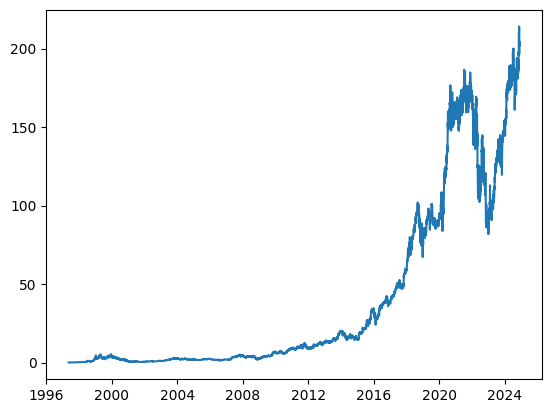

In [ ]:
plt.plot(data['date'], data['close'])

In [ ]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, sequence_length):
    df = dc(df)

    df.set_index('date', inplace=True)

    for i in range(1, sequence_length+1):
        df[f'close(d-{i})'] = df['close'].shift(i)

    df.dropna(inplace=True)

    return df

prepared_df = prepare_dataframe_for_lstm(data, sequence_length)
prepared_df

,close,close(d-1),close(d-2),close(d-3),close(d-4),close(d-5),close(d-6),close(d-7)
date,,,,,,,,
1997-05-27 00:00:00+00:00,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28 00:00:00+00:00,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29 00:00:00+00:00,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30 00:00:00+00:00,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02 00:00:00+00:00,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2024-11-18 00:00:00+00:00,201.699997,202.610001,211.479996,214.100006,208.910004,206.839996,208.179993,210.050003
2024-11-19 00:00:00+00:00,204.610001,201.699997,202.610001,211.479996,214.100006,208.910004,206.839996,208.179993
2024-11-20 00:00:00+00:00,202.880005,204.610001,201.699997,202.610001,211.479996,214.100006,208.910004,206.839996


In [ ]:
prepared_df_np = prepared_df.to_numpy()
prepared_df_np

array([[Decimal('0.079167'), Decimal('0.075000'), Decimal('0.069792'),
        ..., Decimal('0.085417'), Decimal('0.086458'),
        Decimal('0.097917')],
       [Decimal('0.076563'), Decimal('0.079167'), Decimal('0.075000'),
        ..., Decimal('0.081771'), Decimal('0.085417'),
        Decimal('0.086458')],
       [Decimal('0.075260'), Decimal('0.076563'), Decimal('0.079167'),
        ..., Decimal('0.071354'), Decimal('0.081771'),
        Decimal('0.085417')],
       ...,
       [Decimal('202.880005'), Decimal('204.610001'),
        Decimal('201.699997'), ..., Decimal('214.100006'),
        Decimal('208.910004'), Decimal('206.839996')],
       [Decimal('198.380005'), Decimal('202.880005'),
        Decimal('204.610001'), ..., Decimal('211.479996'),
        Decimal('214.100006'), Decimal('208.910004')],
       [Decimal('197.119995'), Decimal('198.380005'),
        Decimal('202.880005'), ..., Decimal('202.610001'),
        Decimal('211.479996'), Decimal('214.100006')]], dtype=object)

In [ ]:
prepared_df_np

array([[Decimal('0.079167'), Decimal('0.075000'), Decimal('0.069792'),
        ..., Decimal('0.085417'), Decimal('0.086458'),
        Decimal('0.097917')],
       [Decimal('0.076563'), Decimal('0.079167'), Decimal('0.075000'),
        ..., Decimal('0.081771'), Decimal('0.085417'),
        Decimal('0.086458')],
       [Decimal('0.075260'), Decimal('0.076563'), Decimal('0.079167'),
        ..., Decimal('0.071354'), Decimal('0.081771'),
        Decimal('0.085417')],
       ...,
       [Decimal('202.880005'), Decimal('204.610001'),
        Decimal('201.699997'), ..., Decimal('214.100006'),
        Decimal('208.910004'), Decimal('206.839996')],
       [Decimal('198.380005'), Decimal('202.880005'),
        Decimal('204.610001'), ..., Decimal('211.479996'),
        Decimal('214.100006'), Decimal('208.910004')],
       [Decimal('197.119995'), Decimal('198.380005'),
        Decimal('202.880005'), ..., Decimal('202.610001'),
        Decimal('211.479996'), Decimal('214.100006')]], dtype=object)

In [ ]:
#Normalizando os valores do dataset
scaler = MinMaxScaler(feature_range=(-1, 1))
prepared_df_np = scaler.fit_transform(prepared_df_np)

prepared_df_np

array([[-0.99992212, -0.99996106, -1.        , ..., -0.99985399,
        -0.99984426, -0.99973719],
       [-0.99994646, -0.99992212, -0.99995133, ..., -0.99988806,
        -0.99985399, -0.99984426],
       [-0.99995863, -0.99994646, -0.9999124 , ..., -0.9999854 ,
        -0.99988806, -0.99985399],
       ...,
       [ 0.89515447,  0.91132045,  0.88412842, ...,  1.        ,
         0.95150216,  0.93215902],
       [ 0.85310413,  0.89515447,  0.91132088, ...,  0.97551738,
         1.        ,  0.95150216],
       [ 0.84132994,  0.85310413,  0.89515498, ...,  0.89263193,
         0.97551738,  1.        ]])

In [ ]:
X = prepared_df_np[:, 1:]
#Realizando flip para inverter as colunas (d-1 -> d-7) para (d-7 -> d-1)
X = dc(np.flip(X, axis=1))

y = prepared_df_np[:, 0]

X.shape, y.shape

((6921, 7), (6921,))

In [ ]:
X

array([[-0.99973719, -0.99984426, -0.99985399, ..., -0.9999854 ,
        -1.        , -0.99996106],
       [-0.99984426, -0.99985399, -0.99988806, ..., -1.        ,
        -0.99995133, -0.99992212],
       [-0.99985399, -0.99988806, -0.9999854 , ..., -0.99995133,
        -0.9999124 , -0.99994646],
       ...,
       [ 0.93215902,  0.95150216,  1.        , ...,  0.89263193,
         0.88412842,  0.91132045],
       [ 0.95150216,  1.        ,  0.97551738, ...,  0.88412842,
         0.91132088,  0.89515447],
       [ 1.        ,  0.97551738,  0.89263193, ...,  0.91132088,
         0.89515498,  0.85310413]])

In [ ]:
#Definindo o tamanho de treino e do teste com base na portencetagem usada para trainamento
train_size = int(len(X) * porcentage_train) # train_size and test_size 

X_train = X[:train_size]
X_test = X[train_size:]

y_train = y[:train_size]
y_test = y[train_size:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6574, 7), (347, 7), (6574,), (347,))

In [ ]:
#Preparando dimensão extra para o modelo LSTM do pythorch
X_train = X_train.reshape((-1, sequence_length, 1))
X_test = X_test.reshape((-1, sequence_length, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6574, 7, 1), (347, 7, 1), (6574, 1), (347, 1))

In [ ]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6574, 7, 1]),
 torch.Size([347, 7, 1]),
 torch.Size([6574, 1]),
 torch.Size([347, 1]))

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [ ]:
X_test

tensor([[[0.2175],
         [0.2162],
         [0.2177],
         ...,
         [0.2121],
         [0.1873],
         [0.2027]],

        [[0.2162],
         [0.2177],
         [0.1988],
         ...,
         [0.1873],
         [0.2027],
         [0.2216]],

        [[0.2177],
         [0.1988],
         [0.2121],
         ...,
         [0.2027],
         [0.2216],
         [0.2543]],

        ...,

        [[0.9322],
         [0.9515],
         [1.0000],
         ...,
         [0.8926],
         [0.8841],
         [0.9113]],

        [[0.9515],
         [1.0000],
         [0.9755],
         ...,
         [0.8841],
         [0.9113],
         [0.8952]],

        [[1.0000],
         [0.9755],
         [0.8926],
         ...,
         [0.9113],
         [0.8952],
         [0.8531]]])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(input_size, hidden_size, num_layers)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [ ]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

In [ ]:
def train_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [ ]:
def validate_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [ ]:
for epoch in range(num_epochs):
    train_epoch()
    validate_epoch()

Epoch: 1
Batch 100, Loss: 0.343
Batch 200, Loss: 0.155
Batch 300, Loss: 0.075
Batch 400, Loss: 0.032

Val Loss: 0.340
***************************************************

Epoch: 2
Batch 100, Loss: 0.017
Batch 200, Loss: 0.014
Batch 300, Loss: 0.012
Batch 400, Loss: 0.007

Val Loss: 0.095
***************************************************

Epoch: 3
Batch 100, Loss: 0.006
Batch 200, Loss: 0.004
Batch 300, Loss: 0.004
Batch 400, Loss: 0.003

Val Loss: 0.039
***************************************************

Epoch: 4
Batch 100, Loss: 0.003
Batch 200, Loss: 0.002
Batch 300, Loss: 0.002
Batch 400, Loss: 0.002

Val Loss: 0.021
***************************************************

Epoch: 5
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001
Batch 400, Loss: 0.001

Val Loss: 0.015
***************************************************

Epoch: 6
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001
Batch 400, Loss: 0.001

Val Loss: 0.010
***************************

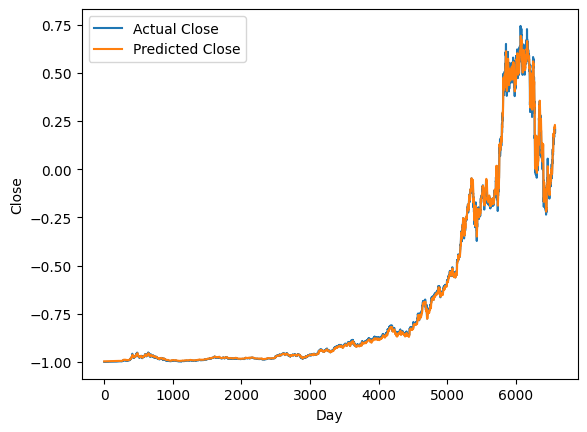

In [ ]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [ ]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], sequence_length+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([  0.39107531,   0.39134321,   0.39120288, ..., 131.01234382,
       131.06340425, 130.0418864 ])

In [ ]:
dummies = np.zeros((X_train.shape[0], sequence_length+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

C:\Users\marci\AppData\Local\Temp\ipykernel_5312\1182887007.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dummies[:, 0] = y_train.flatten()


array([7.91697863e-02, 7.65609526e-02, 7.52597251e-02, ...,
       1.29779998e+02, 1.27129997e+02, 1.28779999e+02])

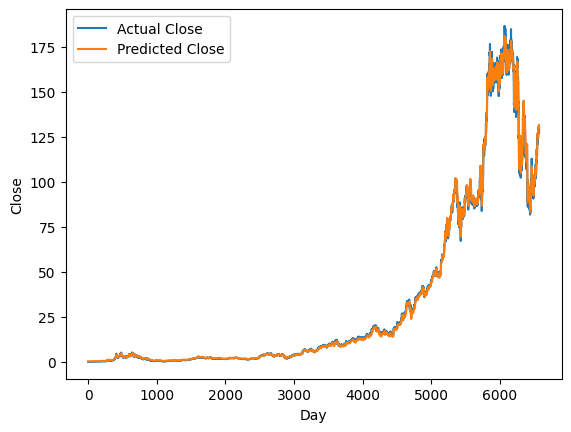

In [ ]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [ ]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], sequence_length+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([129.9211529 , 130.80529875, 132.93315023, 134.66178957,
       135.26565483, 135.16841996, 135.82944994, 134.13427575,
       132.80382161, 131.48758848, 130.83107134, 130.14004935,
       129.81690799, 131.36484254, 133.1040097 , 133.55169576,
       132.22664746, 131.32533689, 134.86323107, 138.69118738,
       140.61590066, 140.80681753, 140.72527394, 140.30129063,
       140.74555778, 140.19284224, 138.77784658, 137.24117339,
       135.86559727, 135.6471824 , 135.55852033, 136.18300749,
       135.20019798, 134.92456099, 134.70776627, 135.30067954,
       135.90569932, 137.47487131, 138.66367024, 138.98347881,
       138.2947212 , 138.60637796, 139.03319973, 141.21275587,
       142.18727325, 144.073039  , 145.23831379, 144.19250955,
       143.03089607, 141.20035594, 139.0776711 , 135.22821264,
       132.61207233, 132.04056554, 129.87173177, 128.52724478,
       127.79053949, 127.9437112 , 129.08601677, 128.11821921,
       128.27031931, 127.87681917, 128.41029057, 128.99

In [ ]:
dummies = np.zeros((X_test.shape[0], sequence_length+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

C:\Users\marci\AppData\Local\Temp\ipykernel_5312\2906197738.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dummies[:, 0] = y_test.flatten()


array([130.80000294, 134.30000366, 134.679994  , 133.55999747,
       132.83000243, 135.3600002 , 129.96000634, 129.99999995,
       128.80000344, 129.13000495, 128.14999404, 128.25000039,
       132.21000737, 133.67999265, 131.69000272, 128.21000678,
       128.91000341, 139.57000712, 142.22000168, 139.94000225,
       137.85000755, 138.5599994 , 138.41000422, 140.57000687,
       137.66999803, 135.07000825, 133.97999736, 133.22000074,
       134.679994  , 134.24999889, 135.52000335, 131.8399963 ,
       133.25999435, 133.13999917, 134.9100051 , 135.07000825,
       138.00999476, 138.11999632, 137.27000451, 135.3600002 ,
       137.85000755, 138.2299947 , 143.10000464, 141.22999714,
       144.8500058 , 144.72000105, 140.39000054, 139.97999586,
       137.63000442, 135.28999225, 129.33000171, 129.11999539,
       131.27000442, 125.98000255, 125.98000255, 125.98000255,
       127.12000227, 129.46000647, 124.72000127, 127.0000007 ,
       125.95999937, 127.95999887, 128.2599956 , 129.47

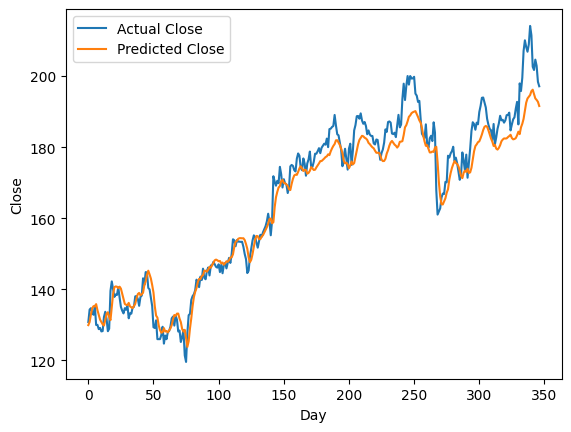

In [ ]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()